In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

#feature importance and corelation
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from sklearn import utils
import seaborn as sns


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_datasets(filename, x_features, y_feature):
    '''
    Читає вхідний файл
    
    Параметри:
    filename - шлях до вхідного файлу з даними
    
    Результат:
    X - набір характеристик
    y - набір передбачуваних величин
    '''
    
    df = pd.read_csv(filename, delimiter='\t')

    data_features = x_features + y_feature
    data, X, y = df[data_features], df[x_features], df[y_feature].astype(float)

    #df = df[(df['user_score'] != 'tbd') & (df['metascore'] != 'tbd')]
    #data = df.sample(n = 1000)
    # , "platform"
    #, "genre(s)"
    #X, y = data[["metascore","publisher"]], data["user_score"].astype(float)
    return  data, X, y


data, X, y = load_datasets('real_estate.tsv', ["area", "rooms"], ["price"])


#print(y)

In [3]:
def split_datasets(X, y, test_size = 0.2):
    '''
    Розбиває дані на 2 датасети: тренувальний та тестувальний.
    
    Параметри:
    X - набір характеристик
    y - набір передбачуваних величин
    test_size - розмір тестового датасету
    
    Результат:
    X_train - набір тренувальних прикладів
    X_test - набір тестових прикладів
    y_train - вектор величин, що передбачаємо для тренувального датасету
    y_test - вектор величин, що передбачаємо для тестового датасету
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=12)
    return X_train, X_test, y_train, y_test

In [4]:
def plot_data(X_train, X_test, y_train, y_test):
    '''
    Функція для відображення розподілу тренувальних та тестових даних (для однієї змінної)
    '''
    plt.scatter(X_train, y_train, marker='^', c='green')
    plt.scatter(X_test, y_test, marker='o', c='red')
    plt.show()

In [5]:
def normalize(X):
    '''
    Нормалізує датасет з характеристиками
    
    Параметри:
    X - набір характеристик
    
    Результат:
    X - набір нормалізованих характеристик
    mean - вектор середніх значень характеристик
    std - вектор стандартних девіацій характеристик
    '''
    ##################
    # Заповнити змінні
    ##################
    mean = np.mean(X)
    std = np.std(X)
    X_new = (X - mean)/std
    return X_new, mean, std

In [6]:
def prepare_X(X):
    '''
    Формує датасет з рисами, де першою колонкою буде колонка з одиницями.
    
    Параметри:
    X - вхідний датасет з прикладами, по одному в рядок. Кожна риса - відповідна колонка.
    
    Результат:
    X_new - датасет, який складається з колонки одиниць, а решта колонок з X    
    '''
    m = X.shape[0]
    ones = np.ones((m, 1))
    X_new = np.array(X[:])
    X_new = np.column_stack((ones, X_new))
    return X_new

In [7]:
def hypothesis(X, theta):
    '''
    Обчислює значення передбачуваної величини для вхідної матриці X та вектора параметрів thetha.
    
    Параметри:
    X - матриця з рисами. Перша колонка - одиниці. Друга - дані риси.
    thetha - вектор параметрів: [thetha0, thetha1]
    
    Результат:
    Матриця значень шуканої величини для прикладів з X
    '''
    
    ######################
    # Один рядок коду

    h_thetha = np.dot(X, theta)
    ######################
    return h_thetha

#print(hypothesis([[1, 1], [2, 3]], [3, 2]))


In [8]:
def cost_function(X, y, theta):
    '''
    Функція для обчислення штрафної функції J.
    
    Параметри:
    X - тренувальний датасет. 0 - колонка з одиниць, далі - реальні риси
    y - точні значення передбачуваної величини
    thethe - вектор параметрів регресії
    
    Результат:
    Дійсне число - значення штрафної функції для набору прикладів X та параметрів thetha
    '''
    
    m = X.shape[0]
    if m == 0:
        return None
    ######################
    J = 1/(2*m) * sum((hypothesis(X, theta) - y) ** 2)
    # 1-2 рядки коду
    ######################
    return J

In [9]:
def derivative(X, y, theta):
    m = X.shape[0]
    '''
    Функція для обчислення похідних штрафної функції J по thetha.
    
    Параметри:
    X - тренувальний датасет. 0 - колонка з одиниць, далі - реальні риси
    y - точні значення передбачуваної величини
    thetha - вектор параметрів регресії
    
    Результат:
    Вектор похідних d_thetha
    '''
    ######################
    # 1 рядок коду
    d_theta = 1/m*(hypothesis(X, theta) - y).dot(X)
    ######################
    return d_theta

In [10]:
def gradient_descent(X, y, theta, alpha, num_iters, print_J = True):
    '''
    Функція, що реалізує градієнтний спуск для метода лінійної регресії.
    
    Параметри:
    X - тренувальний датасет. 0 - колонка з одиниць, далі - реальні риси
    y - точні значення передбачуваної величини
    thetha - вектор початкових параметрів регресії
    alpha - швидкість навчання
    num_iters - кількість ітерацій
    print_J - виведення штрафної функції на екран після кожної ітерації
    
    Результат:
    theta - оптимальні значення параметрів регресії
    J_history - масив історичних значень штрафної функції після кожної ітерації
    '''
    m = X.shape[0]
    J_history = []
    J = cost_function(X, y, theta)
    if print_J == True:
        print(J)
    J_history.append(J)
    for i in range(num_iters):
        ######################
        # Використати написані вище функції
        delta = None
        theta = theta - alpha * derivative(X, y, theta)
        J = cost_function(X, y, theta)
        ######################
        if print_J == True:
            print(J)
        J_history.append(J)
    return theta, J_history

In [11]:
def plot_J(J_history):
    '''
    Функція для виведення графіків штрафної функції для різних значень параметрів на вхідних даних
    
    Параметри:
    X - тренувальний датасет. 0 - колонка з одиниць, далі - реальні риси
    y - точні значення передбачуваної величини
    '''
    
    x = np.arange(0, len(Js))
    plt.plot(x, Js)
    plt.show()

In [12]:
def plot_feature_importance(X, y):
    # encoding 
    model = ExtraTreesClassifier()
    lab_enc = preprocessing.LabelEncoder()
    encoded = lab_enc.fit_transform(y)
    print(encoded)
    model.fit(X,encoded)
    #use inbuilt class feature_importances of tree based classifiers
    print(model.feature_importances_) 
    #plot graph of feature importances for better visualization
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.show()

In [13]:
def plot_feature_correlations(X):
    print(X.corr())
    corrmat = X.corr()
    top_corr_features = corrmat.index
    sns.heatmap(X[top_corr_features].corr(),annot=True,cmap="RdYlGn")


In [14]:
def plot_feature_scatters(X):
    sns.pairplot(X)

## Основний код програми

Отримання датасетів та видрук їх параметрів.

In [15]:
filename = "real_estate.tsv"
x_features = ["area", "rooms"]
y_feature = ["price"]
data_features = x_features + y_feature
    
df = pd.read_csv(filename, delimiter='\t')
df = df.sample(40)

df, X, y = df[data_features], df[x_features], df[y_feature].astype(float)

print('Dataset: X={}, y={}'.format(X.shape, y.shape))

Dataset: X=(40, 2), y=(40, 1)


# Features correlation

           area     rooms     price
area   1.000000  0.559881  0.882501
rooms  0.559881  1.000000  0.445414
price  0.882501  0.445414  1.000000


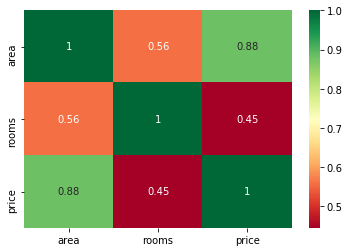

In [16]:
plot_feature_correlations(df)

# Features scatter pairplots

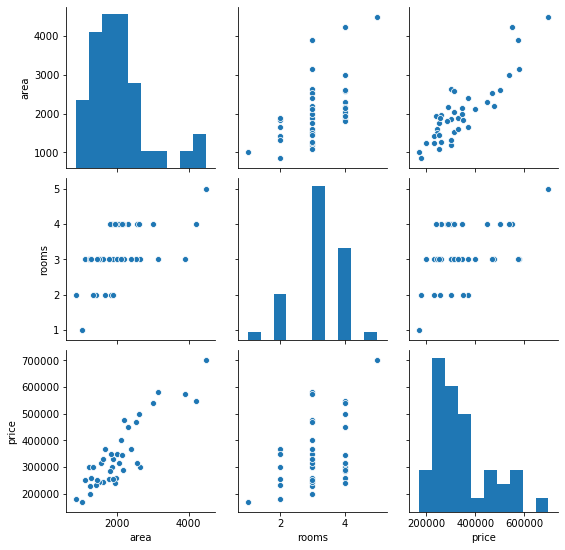

In [17]:
plot_feature_scatters(df)

Розбиття датасету на частини:

In [18]:
X_train, X_test, y_train, y_test = split_datasets(X, y, test_size=0.2)
print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

Training set: X=(32, 2), y=(32, 1)
Test set: X=(8, 2), y=(8, 1)


Нормалізація, заповнення пустих даних:

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

cat = []
num = ["area", "rooms"]


num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler',  StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder(categories='auto'))
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num),
    ('cat', cat_pipeline, cat)
])

_, mean, std = normalize(X_train)

X_train_norm = full_pipeline.fit_transform(X_train)
X_train_norm.shape

(32, 2)

# Sklearn

In [20]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print('Coefficients: \n', regr.coef_)
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [[   130.91715447 -10694.20293818]]
Mean squared error: 1227573574.34
Coefficient of determination: 0.94


Підготовка тренувальних даних (додавання 0-колонки з одиницями). Ініціалізація параметрів регресії (0, 0): 

In [21]:
X_train_norm, mean, std = normalize(X_train)
X = prepare_X(X_train_norm)
print(X.shape)

theta = np.zeros(X.shape[1])

(32, 3)


Для спрощення записів аліас для вектора передбачуваних значень

In [22]:
y = np.array(y_train.iloc[:, 0])
y_test = np.array(y_test.iloc[:, 0])

У випадку використання ВСІХ даних для тренування (test_size=0.0), штрафна функція має повернути величину близьку до 32.072.

In [23]:
print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))
print(cost_function(X, y, theta))

X: (32, 3)
y: (32,)
63969590625.078125


Налаштування гіперпараметрів регресії: швидкості навчання та кількості ітерацій.

In [24]:
alpha = 1
num_iters = 500

Запуск градієнтного спуску та видрук знайдених оптимальних значень на екран. У випадку використання всіх даних для тренування, результати будуть близькі до Theta 0: -3.63; Theta 1: 1.17

In [25]:
new_theta, Js = gradient_descent(X, y, theta, alpha, num_iters, False)
print('Theta 0: {}; Theta 1: {}; Theta 2: {}'.format(new_theta[0], new_theta[1], new_theta[2]))

Theta 0: 338912.40625; Theta 1: 100112.91812273297; Theta 2: -8179.219328369175


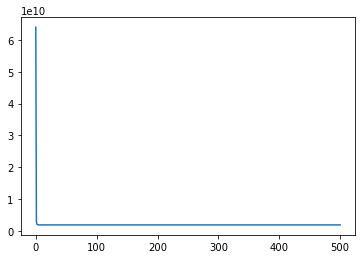

In [26]:
plot_J(Js)

Відображення знайденої апроксимації разом із тренувальними даними.

Оцінка похибки апроксимації на тестових даних (test_size має бути більше 0.0 та менше 1.0).

In [27]:
####################
# Нормалізувати тестовий датасет, використовуючи mean, std з тренувального
####################

X_test_proc = (X_test - mean) / std
X_test_proc = prepare_X(X_test_proc)
y_test_pred = hypothesis(X_test_proc, new_theta)
print(y_test)
print(y_test_pred)
rel_diff = np.abs(np.divide(y_test - y_test_pred, y_test)) * 100

res = pd.DataFrame({'X_area' : X_test.loc[:,"area"], 'X_price' : X_test.loc[:,"rooms"], 'y_actual' : y_test, 'price' : y_test_pred, 'err' : rel_diff})
print(res.head(20))
print(cost_function(X_test_proc, y_test, new_theta))

[699900. 399900. 179900. 347000. 285900. 314900. 252900. 329999.]
[641433.74340873 352024.82456428 198810.75010126 338409.44049901
 302971.89536528 332951.92373978 307905.74350661 324008.55350689]
    X_area  X_price  y_actual          price        err
13    4478        5  699900.0  641433.743409   8.353516
0     2104        3  399900.0  352024.824564  11.971787
44     852        2  179900.0  198810.750101  10.511812
11    2000        3  347000.0  338409.440499   2.475666
34    1811        4  285900.0  302971.895365   5.971282
32    2040        4  314900.0  332951.923740   5.732589
20    1767        3  252900.0  307905.743507  21.749997
12    1890        3  329999.0  324008.553507   1.815292
613786787.1688374


In [28]:
#plot_feature_importance(df, y)